In [1]:
import numpy as np
img=np.load('./img.npy')
anno=np.load('./anno.npy')
label=np.load('./label.npy')
print(anno.shape,img.shape,label.shape)

(182,) (182,) (182, 7, 7, 19)


In [2]:
import torch
import torchvision.models as models
import numpy as np
import json
import os
import cv2
import collections

#config
device = torch.device('cuda:0')

In [3]:
print(anno[0])
anno_path='.'
print(img[0])
img_path='./week10_dataset_bak'

/annotations/skypower/55691046201532b95fe2adf875e9dc5.xml
/skypower/55691046201532b95fe2adf875e9dc5.jpg


In [4]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torchvision import transforms
import numpy as np
def default_loader(path):
    return Image.open(path).convert('RGB')

# 创建自己的类：MyDataset, 继承 Dataset类
class MyDataset(Dataset):
    def __init__(self, imgs, labels,data_path=None, transform=None, target_transform=None, loader=default_loader):
        super(MyDataset, self).__init__() # 对继承父类的属性初始化
        # 在__init__()方法中得到图像的路径，然后将图像路径组成一个数组
        self.imgs = imgs
        self.labels=labels
        self.transform = transform
        self.target_transform = target_transform
        self.loader = loader
        self.data_path = data_path

    def __getitem__(self, index):
        # 按照索引读取每个元素的具体内容
        imgName = self.imgs[index]
        imgPath = self.data_path + imgName
        img = self.loader(imgPath)
        label=torch.from_numpy(self.labels[index]).to(torch.float32)
        if self.transform is not None:
            img = self.transform(img)  # 数据标签转换为Tensor
        return img, label

    def __len__(self):
        # 数据集的图片数量
        return len(self.imgs)

In [5]:
# 预处理的设置
# 图片转化为resnet规定的图片大小
# 归一化是减去均值，除以方差
# 把 numpy array 转化为 tensor 的格式
train_tf = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(5),
    transforms.ToTensor(),
    transforms.Normalize([0.557, 0.517, 0.496], [0.210, 0.216, 0.222])])
'''
normMean = [0.55671153 0.51730426 0.49580584]
normStd = [0.21057842 0.21577705 0.222336]
'''
# 数据集加载方式设置
train_data = MyDataset(img,label, data_path=img_path, transform=train_tf)

In [6]:
import torch.nn.functional as F
import torch.nn as nn
class yolo_v1(nn.Module):
    def __init__(self):
        super(yolo_v1,self).__init__()
        model=models.resnet18(pretrained=True)
        self.features=nn.Sequential(model.conv1,
                                     model.bn1,
                                      model.relu,
                                      model.maxpool,
                                      model.layer1,
                                      model.layer2,
                                      model.layer3,
                                      model.layer4)
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(True),
            nn.Linear(4096, 931),)
    def forward(self,x):
        x=self.features(x)
        x=x.view(x.size(0),-1)
        x=self.classifier(x)
        x=F.sigmoid(x)
        x=x.view(-1,7,7,19)
        return x


In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

class yoloLoss(nn.Module):
    def __init__(self,S,B,l_coord,l_noobj):
        super(yoloLoss,self).__init__()
        self.S = S
        self.B = B
        self.l_coord = l_coord
        self.l_noobj = l_noobj

    def compute_iou(self, box1, box2):
        '''Compute the intersection over union of two set of boxes, each box is [x1,y1,W,H].
        Args:
          box1: (tensor) bounding boxes, sized [N,4].
          box2: (tensor) bounding boxes, sized [N,4].
        Return:
          (tensor) iou, sized [N,1].
        '''
        box1_x2=box1[:,0]+box1[:,2]
        box1_y2=box1[:,1]+box1[:,3]
        box2_x2=box2[:,0]+box2[:,2]
        box2_y2=box2[:,1]+box2[:,3]
        i_w=torch.max(torch.min(box1_x2,box2_x2)-torch.max(box1[:,0],box2[:,0]),torch.zeros((box1.size()[0],1)).to(device))
        i_h=torch.max(torch.min(box1_y2,box2_y2)-torch.max(box1[:,1],box2[:,1]),torch.zeros((box1.size()[0],1)).to(device))
        i_area=i_w*i_h
        u_area=box1[:,2]*box1[:,3]+box2[:,2]*box2[:,3]-i_area
        return i_area/(u_area+1e-16)
        
        
    def forward(self,pred_tensor,target_tensor):
        '''
        pred_tensor: (tensor) size(batchsize,S,S,Bx5+14=19) [x,y,w,h,c]
        target_tensor: (tensor) size(batchsize,S,S,30)
        '''
        N = pred_tensor.size()[0]
        coo_mask = target_tensor[:,:,:,4] > 0
        noo_mask = target_tensor[:,:,:,4] == 0
        coo_mask = coo_mask.unsqueeze(-1).expand_as(target_tensor)
        noo_mask = noo_mask.unsqueeze(-1).expand_as(target_tensor)

        coo_pred = pred_tensor[coo_mask].view(-1,19)
        box_pred = coo_pred[:,:5].contiguous().view(-1,5) #box[x1,y1,w1,h1,c1]
        class_pred = coo_pred[:,5:]                       #[x2,y2,w2,h2,c2]
        
        coo_target = target_tensor[coo_mask].view(-1,19)
        box_target = coo_target[:,:5].contiguous().view(-1,5)
        class_target = coo_target[:,5:]

        # compute not contain obj loss
        noo_pred = pred_tensor[noo_mask].view(-1,19)
        noo_target = target_tensor[noo_mask].view(-1,19)
        noo_pred_mask = torch.cuda.ByteTensor(noo_pred.size())
        noo_pred_mask.zero_()
        noo_pred_mask[:,4]=1
        noo_pred_c = noo_pred[noo_pred_mask] #noo pred只需要计算 c 的损失 size[-1,2]
        noo_target_c = noo_target[noo_pred_mask]
        nooobj_loss = F.mse_loss(noo_pred_c,noo_target_c,size_average=False)

        #let confidence score == iou between pred and gt
        
        iou=self.compute_iou(box_pred[:,:4],box_target[:,:4])
        
        contain_loss = F.mse_loss(iou,box_target[:,4],size_average=False)
        
        
        loc_loss = F.mse_loss(box_pred[:,:2],box_target[:,:2],size_average=False) + F.mse_loss(torch.sqrt(box_pred[:,2:4]),torch.sqrt(box_target[:,2:4]),size_average=False)
        
    
        #class loss
        class_loss = F.mse_loss(class_pred,class_target,size_average=False)
        #self.l_coord*loc_loss+ contain_loss  + self.l_noobj*nooobj_loss + class_los
        return ( self.l_coord*loc_loss+contain_loss  + self.l_noobj*nooobj_loss + class_loss  )/N

In [8]:
lr=0.0001
net=yolo_v1().to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=lr,weight_decay=1e-4)
criterion = yoloLoss(7,1,2.5,0.5).to(device)
train_loader = DataLoader(dataset=train_data, batch_size=64, shuffle=True)

In [ ]:
epoches=70
net.train()
for epoch in range(epoches):
    print(f"epoch: {epoch+1}")
    for idx, (img, label) in enumerate(train_loader):
        images = img.to(device)
        labels = label.to(device)
        output = net(images)
        loss = criterion(output, labels)
        if loss<1:break
        loss.backward()  # 损失反向传播
        optimizer.step()  # 更新梯度
        # scheduler.step()
        optimizer.zero_grad()  # 梯度清零
        if idx % 2 == 0:
            print(f"current loss = {loss.item()}")

In [9]:
net=(torch.load('./model.pkl'))

In [10]:
img=np.load('./img.npy')
anno=np.load('./anno.npy')
label=np.load('./label.npy')
test_data = MyDataset(img[:20],label[:20], data_path=img_path, transform=train_tf)
test_loader = DataLoader(dataset=test_data, batch_size=1, shuffle=True)


/home/ma-user/anaconda3/envs/Pytorch-1.0.0/lib/python3.6/site-packages/torch/nn/functional.py:1332: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/ma-user/anaconda3/envs/Pytorch-1.0.0/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 1
current loss = 0.6197609901428223
Counter({4: 21, 6: 8, 9: 4, 5: 4, 1: 3, 13: 2, 12: 2, 7: 2, 0: 1, 2: 1, 10: 1})
(49,)


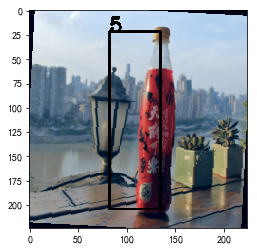

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


current loss = 0.886847972869873
Counter({4: 18, 6: 7, 9: 4, 2: 4, 1: 3, 0: 3, 13: 2, 12: 2, 5: 2, 7: 2, 8: 1, 10: 1})
(49,)


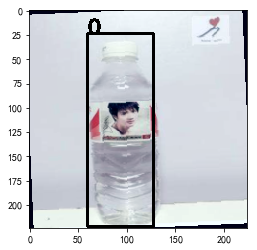

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


current loss = 0.561976432800293
Counter({4: 19, 6: 8, 9: 4, 5: 3, 1: 3, 13: 2, 12: 2, 7: 2, 0: 2, 2: 2, 8: 1, 10: 1})
(49,)


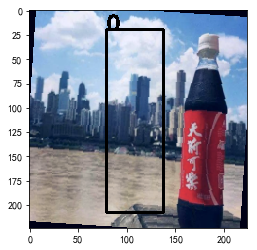

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


current loss = 0.32493144273757935
Counter({4: 15, 6: 6, 13: 4, 2: 4, 5: 4, 9: 4, 8: 3, 1: 3, 0: 3, 7: 1, 3: 1, 12: 1})
(49,)


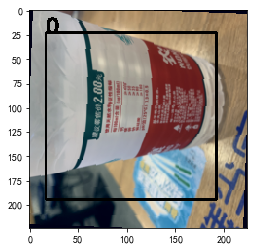

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


current loss = 1.6779658794403076
Counter({4: 14, 6: 6, 2: 5, 5: 5, 13: 4, 0: 4, 1: 3, 9: 3, 8: 2, 7: 2, 3: 1})
(49,)


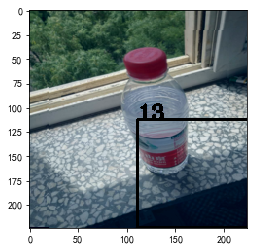

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


current loss = 3.0811564922332764
Counter({4: 13, 0: 8, 6: 6, 5: 5, 13: 4, 2: 4, 1: 3, 8: 2, 7: 2, 9: 2})
(49,)


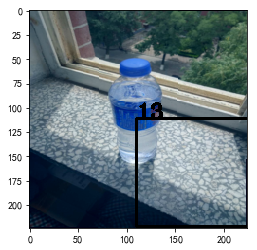

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


current loss = 1.7013286352157593
Counter({4: 21, 6: 9, 9: 4, 5: 3, 1: 3, 13: 2, 12: 2, 7: 2, 0: 1, 2: 1, 10: 1})
(49,)


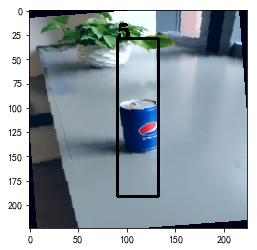

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


current loss = 10.473319053649902
Counter({4: 21, 6: 8, 9: 5, 5: 4, 13: 3, 12: 2, 1: 2, 7: 2, 0: 1, 10: 1})
(49,)


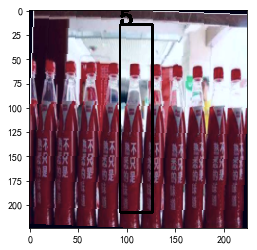

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


current loss = 2.5029358863830566
Counter({4: 14, 6: 6, 5: 6, 2: 5, 13: 4, 0: 4, 1: 3, 8: 2, 7: 2, 9: 2, 3: 1})
(49,)


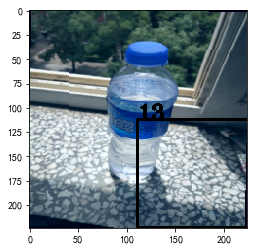

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


current loss = 0.7345725297927856
Counter({4: 18, 6: 8, 2: 4, 0: 4, 9: 3, 1: 3, 13: 2, 5: 2, 7: 2, 8: 1, 12: 1, 10: 1})
(49,)


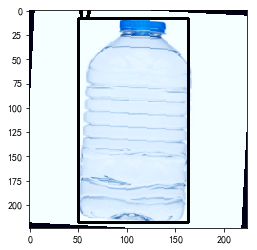

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


current loss = 1.125684142112732
Counter({4: 21, 6: 6, 9: 4, 5: 4, 13: 3, 12: 2, 1: 2, 7: 2, 2: 2, 8: 1, 0: 1, 10: 1})
(49,)


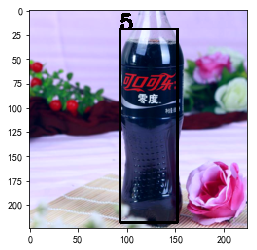

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


current loss = 0.9176317453384399
Counter({4: 18, 6: 9, 9: 4, 5: 3, 1: 3, 13: 2, 7: 2, 0: 2, 2: 2, 8: 1, 12: 1, 3: 1, 10: 1})
(49,)


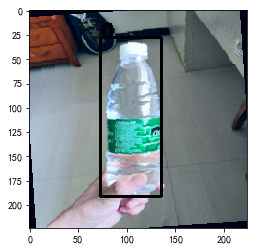

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


current loss = 1.1263506412506104
Counter({4: 18, 6: 8, 9: 4, 5: 4, 1: 3, 13: 2, 12: 2, 7: 2, 0: 2, 2: 2, 8: 1, 10: 1})
(49,)


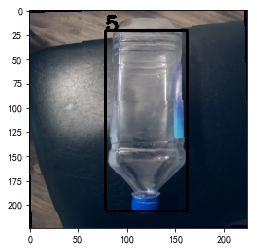

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


current loss = 0.709984540939331
Counter({4: 16, 6: 7, 5: 5, 13: 3, 8: 3, 2: 3, 1: 3, 9: 3, 7: 2, 0: 2, 12: 1, 3: 1})
(49,)


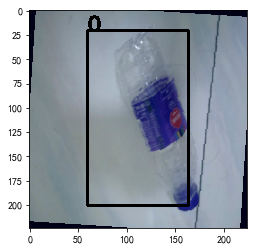

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


current loss = 0.8714865446090698
Counter({4: 22, 6: 7, 9: 4, 5: 3, 1: 3, 13: 2, 7: 2, 0: 2, 2: 2, 12: 1, 10: 1})
(49,)


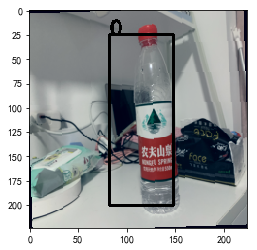

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


current loss = 0.8973139524459839
Counter({4: 16, 6: 7, 13: 4, 8: 3, 2: 3, 5: 3, 1: 3, 9: 3, 0: 3, 7: 2, 12: 1, 3: 1})
(49,)


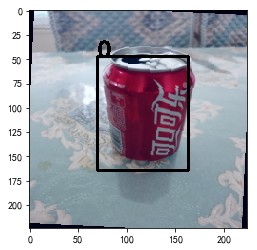

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


current loss = 0.6596482992172241
Counter({4: 18, 6: 6, 5: 4, 13: 3, 2: 3, 1: 3, 9: 3, 0: 3, 8: 2, 7: 2, 12: 1, 3: 1})
(49,)


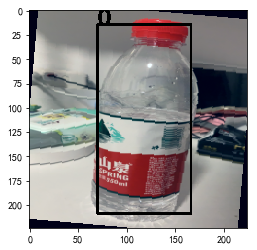

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


current loss = 1.4004075527191162
Counter({4: 15, 5: 7, 6: 6, 2: 4, 1: 4, 13: 3, 8: 3, 9: 2, 0: 2, 7: 1, 3: 1, 11: 1})
(49,)


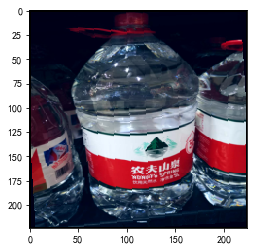

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


current loss = 1.9729828834533691
Counter({4: 23, 6: 6, 9: 4, 13: 3, 0: 3, 12: 2, 1: 2, 7: 2, 5: 2, 2: 1, 10: 1})
(49,)


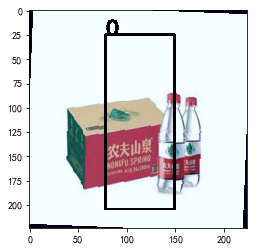

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


current loss = 1.7115306854248047
Counter({4: 18, 6: 9, 5: 4, 9: 3, 1: 3, 13: 2, 12: 2, 7: 2, 0: 2, 2: 2, 8: 1, 10: 1})
(49,)


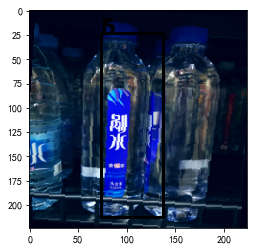

In [12]:
from PIL import Image
import matplotlib.pyplot as plt
from torchvision.transforms import ToPILImage
import cv2 as cv
epoches=1
normMean = [0.557, 0.517, 0.496]
normStd = [0.210, 0.216, 0.222]
normMean.reverse()
normStd.reverse()
net.eval()
for epoch in range(epoches):
    print(f"epoch: {epoch+1}")
    for idx, (img, label) in enumerate(test_loader):
        images = img.to(device)
        labels = label.to(device)
        output = net(images)
        loss = criterion(output, labels)
        print(f"current loss = {loss.item()}")
        img = img[0,:,:,:].numpy()
        img = np.transpose(img, (1, 2, 0)) 
        pred=output.view(7*7,19).detach().cpu().numpy()
        ind=list(pred[:,4]).index(max(pred[:,4]))
        class_=np.argmax(pred[:,5:],axis=1)
        from collections import Counter
        print(Counter(class_))
        print(class_.shape)
        img[:,:,0] = img[:,:,0]*normStd[0] + normMean[0]
        img[:,:,1] = img[:,:,1]*normStd[1] + normMean[1]
        img[:,:,2] = img[:,:,2]*normStd[2] + normMean[2]
        img=img.copy() 
        x1=int(224*pred[ind][0])
        y1=int(224* pred[ind][1])
        x2=int(224*(pred[ind][0]+pred[ind][2]))
        y2=int(224*(pred[ind][1]+pred[ind][3]))
        cv.rectangle(img, (x1,y1), (x2, y2), (0, 0, 0), thickness=2)
        cv.putText(img, str(class_[ind]), (x1, y1), cv.FONT_HERSHEY_COMPLEX, 0.7, (0, 0, 0),thickness=2)
        plt.ion()
        plt.imshow((img))
        plt.pause(5)
        plt.close()